In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import radians, sin, cos, sqrt, atan2

In [3]:
# Load location data from a CSV file
df = pd.read_csv(r'data/vpt_locations.csv')

# Define a function to calculate the distance between two coordinates using the Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Compute the differences in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of the Earth in kilometers
    return r * c  # Return the distance in kilometers

# Extract location names, latitudes, and longitudes into separate lists
locations = df['Location'].tolist()
latitudes = df['Lat'].tolist()
longitudes = df['Lon'].tolist()

# Compute the distance matrix between all location pairs
distance_matrix = []
for i in range(len(locations)):
    row = []
    for j in range(len(locations)):
        distance = haversine(longitudes[i], latitudes[i], longitudes[j], latitudes[j])
        row.append(distance)
    distance_matrix.append(row)

# Convert the list of lists into a NumPy array
distance_matrix = np.array(distance_matrix)

# Save the distance matrix to a CSV file
np.savetxt(r'data/distance_matrix.csv', distance_matrix, delimiter=",", fmt='%.6f')


In [4]:
# Load the OD (origin-destination) demand matrix from a CSV file
array = np.loadtxt(r'data/demand.csv', delimiter=',')

# Calculate total outflow from each node (row-wise sum)
outflow = array.sum(axis=1)

# Calculate total inflow to each node (column-wise sum) and normalize by 24 time units
inflow = array.sum(axis=0)
inflow /= 24  # Assumes demand matrix is aggregated over 24 time units (e.g., hours)

# Print the total arrival rate (should equal total departure rate if balanced)
print(np.sum(inflow))

# Compute the choice probability matrix: probability of going from i to j
# Each row of the matrix sums to 1 (or close to it, depending on zero outflows)
outflow_ratio = array / outflow[:, np.newaxis]

# Save the arrival rate vector and choice probability matrix to CSV files
np.savetxt(r'data/arrival_rate_vector.csv', inflow, delimiter=',', fmt='%.5f')
np.savetxt(r'data/choice_probability_matrix.csv', outflow_ratio, delimiter=',', fmt='%.5f')

# Define a function to check if a Markov chain is irreducible
def is_irreducible(matrix):
    n = matrix.shape[0]
    reachability = np.copy(matrix)  # Initialize reachability matrix with one-step transitions
    for i in range(2, n + 1):  # Compute higher powers to check for multi-step reachability
        reachability = np.dot(reachability, matrix)
        reachability[reachability > 0] = 1  # Binary reachability: 1 if a path exists

    # A chain is irreducible if every state is reachable from every other state
    return np.all(reachability > 0)

# Check and report whether the Markov chain defined by the transition matrix is irreducible
if is_irreducible(outflow_ratio):
    print("This Markov chain is irreducible.")
else:
    print("This Markov chain is not irreducible.")

3985.5
This Markov chain is irreducible.


In [5]:
# Read the choice probability matrix (transition probabilities between vertiports)
P = np.loadtxt(r'data/choice_probability_matrix.csv', delimiter=',')
print(P.shape)

# A set of vertiport locations (assumes df is already defined)
locations = df['Location'].tolist()

# Define all possible flight corridors as (origin, destination) pairs, excluding self-loops
flight_corridors = [(i, j) for i in locations for j in locations if i != j]

# Define all nodes in the network: vertiports and flight corridors
nodes = locations + flight_corridors

# Create a mapping from each node to its index in the combined node list
node_idx = {node: idx for idx, node in enumerate(nodes)}

# Initialize the routing matrix (size: number of nodes x number of nodes)
R = np.zeros((len(nodes), len(nodes)))

# Build the routing matrix by defining valid transitions between nodes
for i_node in nodes:
    for j_node in nodes:
        i_idx = node_idx[i_node]
        j_idx = node_idx[j_node]

        # Case 1: From a vertiport to a flight corridor (only if it departs from that vertiport)
        if isinstance(i_node, str) and isinstance(j_node, tuple):
            entry, exit = j_node
            if i_node == entry:
                # Assign the probability of transitioning from entry to exit
                R[i_idx, j_idx] = P[node_idx[entry], node_idx[exit]]

        # Case 2: From a flight corridor to a vertiport (only if it arrives at that vertiport)
        elif isinstance(i_node, tuple) and isinstance(j_node, str):
            entry, exit = i_node
            if j_node == exit:
                # Deterministic transition: a corridor always leads to its destination
                R[i_idx, j_idx] = 1

# Save the resulting routing matrix to a CSV file
np.savetxt(r'data/routing_matrix.csv', R, delimiter=',', fmt='%.5f')

(10, 10)


In [6]:
# Parameters for UAM (Urban Air Mobility) travel time components
cruise_speed = 241        # Cruise speed in km/h
takeoff_time = 1          # Time required for takeoff (in minutes)
landing_time = 1          # Time required for landing (in minutes)
taxi_time = 2             # Time for taxi-in and taxi-out (in minutes)

# Total fixed time per trip (in minutes): taxi-out + takeoff + landing + taxi-in
procedure_time = takeoff_time + landing_time + taxi_time * 2

# Load the pairwise distance matrix between vertiports (in kilometers)
distances = np.loadtxt(r'data/distance_matrix.csv', delimiter=',')

# Compute the total travel time matrix (in hours)
# Formula: fixed procedure time (converted to hours) + in-flight time based on cruise speed
T = procedure_time / 60 + (distances / cruise_speed)

# Print shape of the resulting travel time matrix
print(T.shape)

# Save the travel time matrix to a CSV file
np.savetxt(r'data/travel_time_matrix.csv', T, delimiter=',', fmt='%.5f')

(10, 10)


In [7]:
# Load routing matrix R
R = np.loadtxt(r'data/routing_matrix.csv', delimiter=',')

# Compute left eigenvectors of R: Solve \pi R = \pi
evals, evecs = np.linalg.eig(R.T)

# Find the eigenvalue closest to 1
idx = np.argmin(np.abs(evals - 1))  

# Extract corresponding eigenvector
pi = np.real(evecs[:, idx])
# print(pi.shape)

np.savetxt(r'data/relative_throughput_vector.csv', pi, delimiter=',', fmt='%.5f')

In [8]:
# Load vertiport and node data
df = pd.read_csv(r'data/vpt_locations.csv')

locations = df['Location'].tolist()
flight_corridors = [(i, j) for i in locations for j in locations if i != j]
nodes = locations + flight_corridors
node_idx = {node: idx for idx, node in enumerate(nodes)}
loc_index = {loc: idx for idx, loc in enumerate(locations)}

# Load required data
R = np.loadtxt(r'data/routing_matrix.csv', delimiter=',')             # Routing matrix
T = np.loadtxt(r'data/travel_time_matrix.csv', delimiter=',')         # Travel time matrix (vertiport level)
D = np.loadtxt(r'data/distance_matrix.csv', delimiter=',')            # Distance matrix (vertiport level)
lambda_vec = np.loadtxt(r'data/arrival_rate_vector.csv', delimiter=',')  # Passenger arrival rate vector
c_usage_vec = np.ones(len(locations))                                 # Initialize usage cost vector
pi_vec = np.loadtxt(r'data/relative_throughput_vector.csv', delimiter=',')  # Relative throughput vector

### Input Parameters ###
tol = 0.5            # Minimum availability requirement
c_fare = 2000        # Fare per km (KRW)
c_usage = 5000       # Vertiport usage cost per operation (KRW)
c_mnt = 2500         # Vehicle maintenance cost per unit (KRW)
lambda_total = 200   # Total arrival rate into the system (passengers/hour)

# Cost Vector Computations
# Compute fare per corridor (distance * fare per km)
c_fare_vec = np.array([D[loc_index[i], loc_index[j]] * c_fare for i, j in flight_corridors])
# Update usage cost vector
c_usage_vec *= c_usage
# Compute effective compen vector (compen minus usage fee)

# Scale arrival rate vector
lambda_props = lambda_vec / np.sum(lambda_vec)      # Normalize
lambda_vec = lambda_props * lambda_total            # Scale to total demand

# Compute base service rates for flight corridors
n_vpt = len(locations)
n_total = len(nodes)
base_mu = np.zeros(n_total)
for f_idx, (j, k) in enumerate(flight_corridors, start=n_vpt):
    base_mu[f_idx] = 1.0 / T[loc_index[j], loc_index[k]]

# Compute service rates for each node (mu_i(1))
mu_1 = np.zeros(n_total)
mu_1[:n_vpt] = lambda_vec          # For vertiports: service rate = arrival rate
mu_1[n_vpt:] = base_mu[n_vpt:]     # For corridors: service rate = 1 vehicle per travel time

# Compute gamma values for optimization
pi_vpt = pi_vec[:n_vpt]
pi_cdr = pi_vec[n_vpt:]
gamma_base = pi_cdr / mu_1[n_vpt:]


# ESS Algorithm: Find optimal number of vehicles
obj_history = []
n_history = []
availability_history = []

W = [np.zeros(n_total)]     # List of response time vectors
L = [np.zeros(n_total)]     # List of queue length vectors
n = 0                       # Current number of vehicles
m_min = -1                  # First n satisfying availability constraint
obj_prev = 0                # Previous objective value

while True:
    n += 1

    # Step 1: Mean Value Analysis (MVA) for response times
    W_vector = np.zeros(n_total)
    for node in nodes:
        idx = node_idx[node]
        if isinstance(node, tuple):  # corridor
            W_vector[idx] = 1.0 / mu_1[idx]
        else: # vertiport
            W_vector[idx] = (1.0 + L[n - 1][idx]) / lambda_vec[loc_index[node]]

    # System throughput: X(n)
    Xn = n / np.dot(pi_vec, W_vector)

    # Queue length: L(n)
    L_vector = Xn * pi_vec * W_vector
    W.append(W_vector)
    L.append(L_vector)

    # Step 2: Check availability constraint
    availability = [
        Xn * pi_vec[node_idx[loc]] / lambda_vec[loc_index[loc]]
        for loc in locations
    ]
    availability_history.append(availability)

    if m_min == -1 and all(a >= tol for a in availability):
        m_min = n  # Minimum fleet size satisfying availability

    # Step 3: Objective function evaluation
    if m_min != -1 and n >= m_min:
        L_corridors = L_vector[n_vpt:]                # Queue lengths on corridors
        Lambda_vector = Xn * pi_vec                   # Flow at each node
        Lambda_vertiports = Lambda_vector[:n_vpt]

        # Objective: max profit = revenue - vertiport usage cost - maintenance cost
        obj_n = (
            np.dot(c_fare_vec, L_corridors)
            - np.dot(c_usage_vec, Lambda_vertiports)
            - c_mnt * n
        )

        obj_history.append(obj_n)
        n_history.append(n)

        # Stop if objective decreases
        if obj_n < obj_prev:
            m_star = n - 1
            break
        obj_prev = obj_n

# Final Results
print(f"Minimum fleet size m_min = {m_min}")
print(f"Optimal fleet size m* = {m_star}")
print(f"Objective value = {obj_prev}")


Minimum fleet size m_min = 30
Optimal fleet size m* = 40
Objective value = 75810.92599985853


FileNotFoundError: [Errno 2] No such file or directory: ''

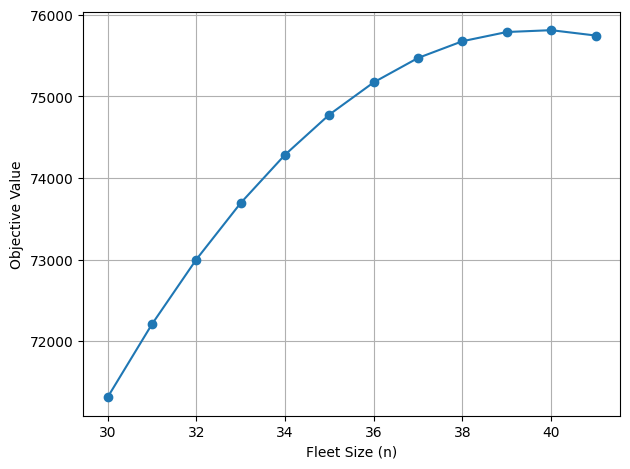

In [9]:
def plot_objective_vs_fleet_size(n_history, obj_history, save_path=None):
    """
    Plot the objective value vs. fleet size.

    Parameters:
        n_history (list): List of fleet sizes evaluated.
        obj_history (list): Corresponding objective values.
        save_path (str, optional): If provided, saves the plot to this file path.
    """
    plt.figure()
    plt.plot(n_history, obj_history, marker='o')
    plt.xlabel('Fleet Size (n)')
    plt.ylabel('Objective Value')
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


def plot_vehicle_availability(locations, availability, m_star, save_path=None):
    """
    Plot vehicle availability at each vertiport.

    Parameters:
        locations (list): List of vertiport names.
        availability (list): Availability values for each vertiport.
        m_star (int): Optimal fleet size (for title).
        save_path (str, optional): If provided, saves the plot to this file path.
    """
    plt.figure()
    plt.bar(locations, availability)
    plt.xlabel('Vertiport')
    plt.ylabel('Vehicle Availability')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()
    print("Final Availability:", availability)
    
    
# Example usage after ESS algorithm
plot_objective_vs_fleet_size(
    n_history=n_history,
    obj_history=obj_history,
    save_path=r"result\fig_objective_vs_fleet_size.png"
)

plot_vehicle_availability(
    locations=locations,
    availability=availability_history[-1],
    m_star=m_star,
    save_path=r"result\fig_veh_availability.png"
)


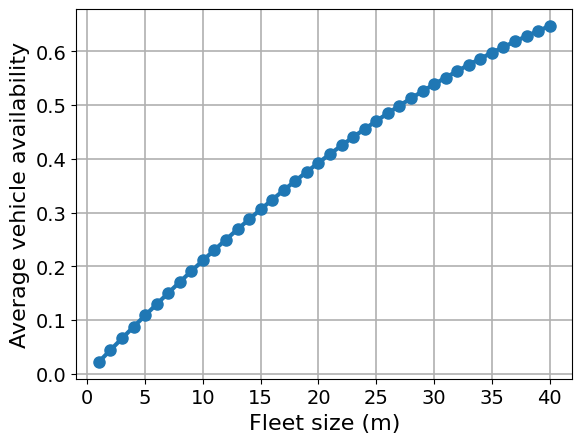

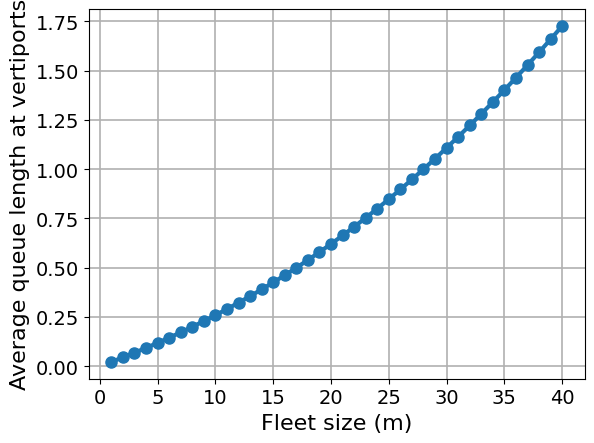

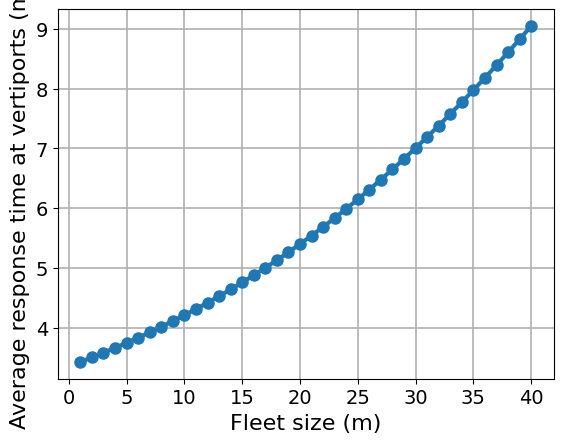

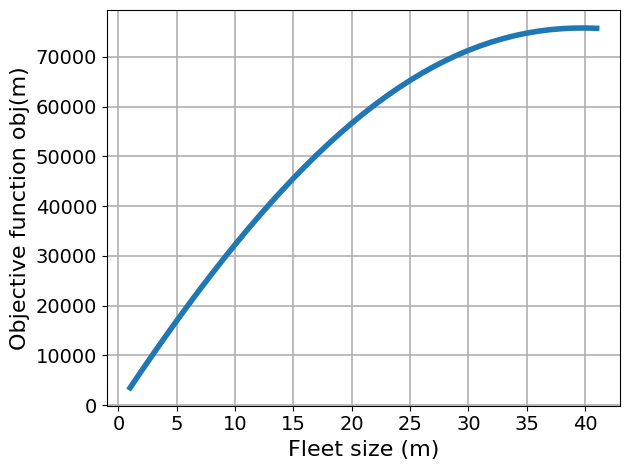

Minimum fleet size: 30
Optimal fleet size: 40


In [ ]:
def run_ess_simulation(
    locations,
    flight_corridors,
    lambda_vec,
    pi_vec,
    T,
    D,
    tol=0.5,
    c_fare=2000,
    c_usage=5000,
    c_mnt=2500,
    lambda_total=200,
    max_fleet=80
):

    # Define indexing
    nodes = locations + flight_corridors
    node_idx = {node: idx for idx, node in enumerate(nodes)}
    loc_index = {loc: idx for idx, loc in enumerate(locations)}

    n_vpt = len(locations)
    n_total = len(nodes)

    # Cost vectors
    c_fare_vec = np.array([
        D[loc_index[i], loc_index[j]] * c_fare for i, j in flight_corridors
    ])
    c_usage_vec = np.ones(n_vpt) * c_usage
    
    # Scale arrival rate
    lambda_vec = lambda_vec / np.sum(lambda_vec) * lambda_total

    # Base service rates
    base_mu = np.zeros(n_total)
    for f_idx, (j, k) in enumerate(flight_corridors, start=n_vpt):
        base_mu[f_idx] = 1.0 / T[loc_index[j], loc_index[k]]

    mu_1 = np.zeros(n_total)
    mu_1[:n_vpt] = lambda_vec
    mu_1[n_vpt:] = base_mu[n_vpt:]

    # ESS loop
    obj_history = []
    n_history = []
    availability_history = []
    avg_availability_history = []
    W, L = [np.zeros(n_total)], [np.zeros(n_total)]
    m_min, obj_prev = -1, 0
    m_star = None
    
    for n in range(1, max_fleet + 1):
        # Response time estimation
        W_vector = np.zeros(n_total)
        for node in nodes:
            idx = node_idx[node]
            if isinstance(node, tuple):
                W_vector[idx] = 1.0 / mu_1[idx]
            else:
                W_vector[idx] = (1.0 + L[n - 1][idx]) / lambda_vec[loc_index[node]]

        Xn = n / np.dot(pi_vec, W_vector)
        L_vector = Xn * pi_vec * W_vector

        A = np.array([
            Xn * pi_vec[node_idx[loc]] / lambda_vec[loc_index[loc]]
            for loc in locations
        ])

        avg_availability_history.append(A.mean())
        availability_history.append(A)
        W.append(W_vector)
        L.append(L_vector)

        # Objective evaluation
        L_corridors = L_vector[n_vpt:]
        Lambda_vector = Xn * pi_vec
        Lambda_vertiports = Lambda_vector[:n_vpt]
        
        obj_n = (
            np.dot(c_fare_vec, L_corridors)
            - np.dot(c_usage_vec, Lambda_vertiports)
            - c_mnt * n
        )
        n_history.append(n)
        obj_history.append(obj_n)

        if m_min == -1 and np.all(A >= tol):
            m_min = n

        if obj_n < obj_prev:
            m_star = n - 1
            break

        obj_prev = obj_n

    # Compute average queue lengths and response times at vertiports
    avg_L_history, avg_W_history = [], []
    for m in range(1, m_star + 1):
        avg_L_history.append(L[m][:n_vpt].mean())
        avg_W_history.append((W[m][:n_vpt] * 60).mean())  # in minutes

    return {
        'm_min': m_min,
        'm_star': m_star,
        'n_history': n_history,
        'obj_history': obj_history,
        'avg_availability_history': avg_availability_history,
        'avg_L_history': avg_L_history,
        'avg_W_history': avg_W_history,
    }

def plot_ess_results(results, save_dir="result"):

    os.makedirs(save_dir, exist_ok=True)

    m_star = results['m_star']

    # Plot average vehicle availability
    plt.figure()
    plt.plot(range(1, m_star + 1), results['avg_availability_history'][:m_star],
             marker='o', linewidth=3, markersize=8)
    plt.xlabel('Fleet size (m)', fontsize=16)
    plt.ylabel('Average vehicle availability', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linewidth=1.2)
    plt.savefig(os.path.join(save_dir, "fig_avg_veh_availability.png"), dpi=600, bbox_inches='tight')
    plt.show()

    # Plot average queue length
    plt.figure()
    plt.plot(range(1, m_star + 1), results['avg_L_history'],
             marker='o', linewidth=3, markersize=8)
    plt.xlabel('Fleet size (m)', fontsize=16)
    plt.ylabel('Average queue length at vertiports', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linewidth=1.2)
    plt.savefig(os.path.join(save_dir, "fig_avg_queue_length.png"), dpi=600, bbox_inches='tight')
    plt.show()

    # Plot average response time
    plt.figure()
    plt.plot(range(1, m_star + 1), results['avg_W_history'],
             marker='o', linewidth=3, markersize=8)
    plt.xlabel('Fleet size (m)', fontsize=16)
    plt.ylabel('Average response time at vertiports (min)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linewidth=1.2)
    plt.savefig(os.path.join(save_dir, "fig_avg_response_time.png"), dpi=600, bbox_inches='tight')
    plt.show()

    # Plot objective function
    plt.figure()
    plt.plot(results['n_history'], results['obj_history'], linewidth=4)
    plt.xlabel('Fleet size (m)', fontsize=16)
    plt.ylabel('Objective function obj(m)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linewidth=1.2)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "fig_obj_function.png"), dpi=600, bbox_inches='tight')
    plt.show()

results = run_ess_simulation(
    locations=locations,
    flight_corridors=flight_corridors,
    lambda_vec=lambda_vec,
    pi_vec=pi_vec,
    T=T,
    D=D,
    tol=0.5,
    lambda_total=200
)

plot_ess_results(results)
print(f"Minimum fleet size: {results['m_min']}")
print(f"Optimal fleet size: {results['m_star']}")

c_pen=0: optimal fleet size m*=40, obj*=75810.93
c_pen=500: optimal fleet size m*=48, obj*=44635.29
c_pen=1000: optimal fleet size m*=55, obj*=18586.29


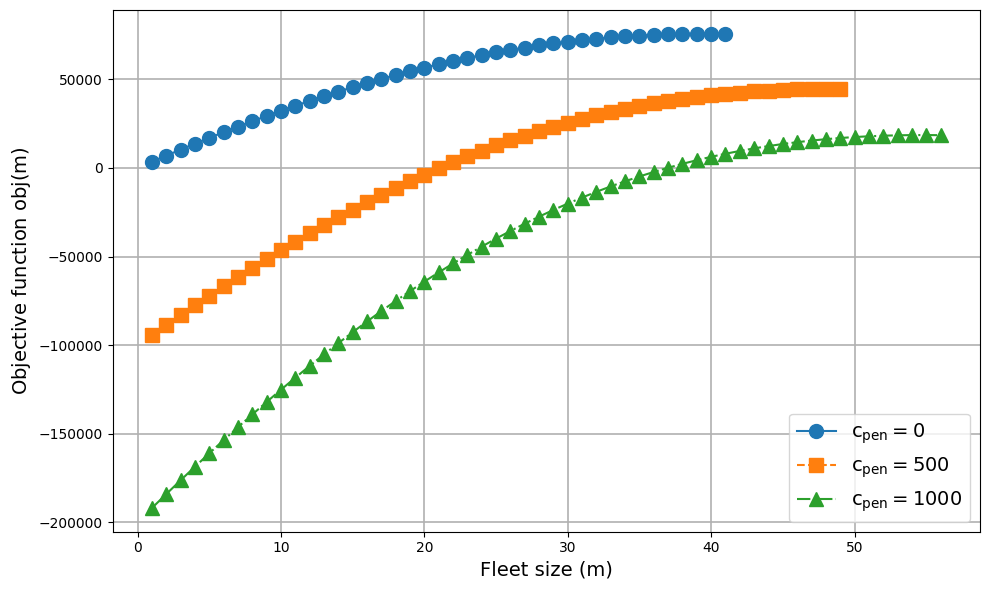

In [ ]:
def run_ess_simulation_compen(
    c_pen=0,
    vpt_csv='data/vpt_locations.csv',
    routing_csv='data/routing_matrix.csv',
    time_csv='data/travel_time_matrix.csv',
    dist_csv='data/distance_matrix.csv',
    arrival_csv='data/arrival_rate_vector.csv',
    throughput_csv='data/relative_throughput_vector.csv',
    tol=0.5,
    c_fare=2000,
    c_usage=5000,
    c_mnt=2500,
    lambda_total=200,
    max_m=100
):
    
    # Load data and set up nodes/corridors
    df        = pd.read_csv(vpt_csv)
    locs      = df['Location'].tolist()
    corridors = [(i, j) for i in locs for j in locs if i != j]
    n_vpt     = len(locs)
    n_nodes   = n_vpt + len(corridors)
    loc_idx   = {loc: i for i, loc in enumerate(locs)}
    node_list = locs + corridors
    node_idx  = {node: i for i, node in enumerate(node_list)}

    # Load matrices and vectors
    T          = np.loadtxt(time_csv,    delimiter=',')
    D          = np.loadtxt(dist_csv,    delimiter=',')
    lambda_raw = np.loadtxt(arrival_csv, delimiter=',')
    pi_vec     = np.loadtxt(throughput_csv, delimiter=',')

    # Cost and fare vectors
    c_usage_vec = np.ones(n_vpt) * c_usage
    fare_vec    = np.array([D[loc_idx[i], loc_idx[j]] * c_fare 
                            for i, j in corridors])

    # Scale arrival rates to total
    props      = lambda_raw / lambda_raw.sum()
    lambda_vec = props * lambda_total
    
    # Compute mu_1 for each node
    base_mu = np.zeros(n_nodes)
    for idx, (i, j) in enumerate(corridors, start=n_vpt):
        base_mu[idx] = 1.0 / T[loc_idx[i], loc_idx[j]]
    mu_1 = np.zeros(n_nodes)
    mu_1[:n_vpt]   = lambda_vec     # vertiports
    mu_1[n_vpt:]   = base_mu[n_vpt:]  # corridors

    # Perform MVA-ESS to build history
    n_history = []
    obj_history = []
    L_prev = np.zeros(n_nodes)
    obj_prev = -np.inf

    for n in range(1, max_m + 1):
        # MVA: compute response times W and queue lengths L
        W = np.zeros(n_nodes)
        for node in node_list:
            idx = node_idx[node]
            if isinstance(node, tuple):
                W[idx] = 1.0 / mu_1[idx]
            else:
                W[idx] = (1 + L_prev[idx]) / lambda_vec[loc_idx[node]]
        Xn = n / np.dot(pi_vec, W)
        L  = Xn * pi_vec * W

        # Compute compen term from lost arrivals
        A = np.array([Xn * pi_vec[node_idx[loc]] / lambda_vec[loc_idx[loc]] for loc in locs])
        lost_rate = lambda_vec * (1 - A)
        pen_term = c_pen * lost_rate.sum()

        # Objective function including compen
        Lambda_v = Xn * pi_vec[:n_vpt]
        obj = (
            fare_vec.dot(L[n_vpt:])    # fare revenue
        - c_usage_vec.dot(Lambda_v)  # usage fee
        - c_mnt * n                  # maintenance cost
        - pen_term               # compen cost
        )

        # Record history
        n_history.append(n)
        obj_history.append(obj)
        L_prev = L

        # Stop if objective decreases
        if obj < obj_prev:
            m_star = n - 1
            break
        obj_prev = obj

    return n_history, obj_history, m_star


# Plotting
penalties   = [0, 500, 1000]
linestyles  = ['-', '--', '-.']
markers     = ['o', 's', '^']

plt.figure(figsize=(10, 6))
for cp, ls, mk in zip(penalties, linestyles, markers):
    n_hist, obj_hist, m_star = run_ess_simulation_compen(cp)
    # Print optimal results for each compen
    print(f"c_pen={cp}: optimal fleet size m*={m_star}, obj*={obj_hist[m_star-1]:.2f}")

    # Plot the objective curve
    plt.plot(
    n_hist, obj_hist,
    linestyle=ls,
    marker=mk,
    markersize=10,
    label=fr'$c_{{pen}}={cp}$'  # LaTeX-formatted legend
    )

# Configure axes and grid
plt.xlabel('Fleet size (m)', fontsize=14)
plt.ylabel('Objective function $obj(m)$', fontsize=14)
# plt.title('Objective vs Fleet Size with compen Term\nand Optimal Annotations', fontsize=16)
plt.grid(True, linewidth=1.2)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('result/fig_compen_scheme')
plt.show()

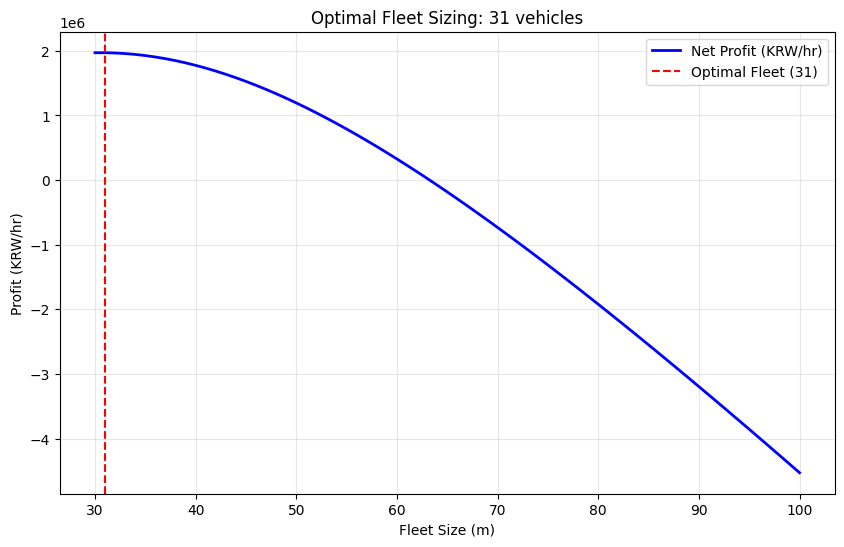

Minimum required fleet size (m_min): 30
Optimal fleet size (m*): 31
Maximum Hourly Profit: 1,970,945 KRW


In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Data Loading & Preprocessing ---
# Load location data
df = pd.read_csv('data/vpt_locations.csv')
locations = df['Location'].tolist()

# Generate flight corridors (all pairs except self-loops)
flight_corridors = [(i, j) for i in locations for j in locations if i != j]

# Define all nodes in the network (Vertiports + Corridors)
nodes = locations + flight_corridors
node_idx = {node: idx for idx, node in enumerate(nodes)}
loc_index = {loc: idx for idx, loc in enumerate(locations)}

# Load System Matrices (Time, Distance, Demand, Throughput)
T = np.loadtxt('data/travel_time_matrix.csv', delimiter=',')
D = np.loadtxt('data/distance_matrix.csv', delimiter=',')
lambda_raw = np.loadtxt('data/arrival_rate_vector.csv', delimiter=',')
pi_vec = np.loadtxt('data/relative_throughput_vector.csv', delimiter=',')


# --- Input Parameters (Refined for Reality) ---
tol = 0.5             # Minimum availability requirement (Service Level Agreement)

c_fare = 3750 # KRW / km
c_usage = 7500 # 4500 KRW / ops
c_mnt = 150000 # lease cost (40,000) + battery cost (85,000) + maintenance cost (25,000) 
c_coupon = 60000 

lambda_total = 200    # Total system demand (passengers/hour)


# --- Cost & Rate Vector Calculations ---

# 1. Fare Vector (KRW per trip)
# Calculated as Distance * Fare_per_km for each corridor
c_fare_vec = np.array([
    D[loc_index[i], loc_index[j]] * c_fare for i, j in flight_corridors
])

# 2. Vertiport Usage Cost Vector (KRW per operation)
c_usage_vec = np.ones(len(locations)) * c_usage

# 3. Arrival Rate Scaling
# Normalize and scale base demand to the target total demand (lambda_total)
lambda_props = lambda_vec / np.sum(lambda_vec)
lambda_vec = lambda_props * lambda_total

# 4. Base Service Rates (mu)
# Service Rate = 1 / Service Time
n_vpt = len(locations)
n_total = len(nodes)
base_mu = np.zeros(n_total)

# For Flight Corridors (IS Nodes): Service Time = Travel Time
for f_idx, (j, k) in enumerate(flight_corridors, start=n_vpt):
    base_mu[f_idx] = 1.0 / T[loc_index[j], loc_index[k]]

# Combine Service Rates
mu_1 = np.zeros(n_total)
mu_1[:n_vpt] = lambda_vec     # Vertiports (Rate depends on arrival in single server view)
mu_1[n_vpt:] = base_mu[n_vpt:] # Corridors (Fixed travel time)

# Split Relative Throughput (pi) for easier calculation later
pi_vpt = pi_vec[:n_vpt]
pi_corridors = pi_vec[n_vpt:]


# --- ESS Algorithm (Simulation Loop) ---
# Mean Value Analysis (MVA) to find performance metrics for each fleet size (n)

obj_history = []          # Stores profit for each n
n_history = []            # Stores fleet size n
availability_history = [] # Stores availability metric

# Initialize MVA variables (Response Time W, Queue Length L)
W = [np.zeros(n_total)]
L = [np.zeros(n_total)]

m_min = -1                # Minimum fleet size to meet availability constraint
max_profit = -np.inf      # Max profit tracker
m_star = 0                # Optimal fleet size tracker

# Iterate fleet size from 1 to 100
for n in range(1, 101):
    
    # --- Step 1: Mean Value Analysis (MVA) ---
    W_vector = np.zeros(n_total)
    for node in nodes:
        idx = node_idx[node]
        if isinstance(node, tuple):  
            # Infinite Server (Flight Corridor): No queuing, W = Service Time
            W_vector[idx] = 1.0 / mu_1[idx]
        else: 
            # Single Server (Vertiport): W includes queuing time
            # W = (1 + L_prev) / ServiceRate
            if lambda_vec[loc_index[node]] > 0:
                W_vector[idx] = (1.0 + L[n - 1][idx]) / lambda_vec[loc_index[node]]
            else:
                W_vector[idx] = 0

    # Calculate System Throughput X(n) using Little's Law
    denom = np.dot(pi_vec, W_vector)
    Xn = n / denom if denom > 0 else 0

    # Update Node Queue Lengths L(n) = Throughput * VisitRatio * ResponseTime
    L_vector = Xn * pi_vec * W_vector
    
    W.append(W_vector)
    L.append(L_vector)

    # --- Step 2: Check Service Availability ---
    # Availability = Throughput / Arrival Rate (saturated if < 1.0)
    availability = []
    for loc in locations:
        lam = lambda_vec[loc_index[loc]]
        if lam > 0:
            a = (Xn * pi_vec[node_idx[loc]]) / lam
            availability.append(a)
        else:
            availability.append(1.0)
            
    availability_history.append(availability)

    # Find minimum fleet size that satisfies tolerance (e.g., > 0.5)
    if m_min == -1 and all(a >= tol for a in availability):
        m_min = n  

    # --- Step 3: Objective Function (Profit) Evaluation ---
    if m_min != -1 and n >= m_min:
        
        # [CRITICAL CORRECTION] Revenue Calculation Logic
        # We must use Flow Rate (Lambda), NOT Queue Length (Stock/L).
        # Revenue comes from passengers arriving/departing, not staying in the air.
        
        # Throughput for corridors (Flights per Hour)
        Lambda_corridors = Xn * pi_corridors
        
        # Throughput for vertiports (Operations per Hour)
        Lambda_vertiports = Xn * pi_vpt

        # Calculate Profit Terms (All units in KRW/Hour)
        # 1. Revenue = (KRW/Flight) * (Flights/Hour)
        revenue = np.dot(c_fare_vec, Lambda_corridors)
        
        # 2. Vertiport Usage = (KRW/Op) * (Ops/Hour)
        cost_vpt = np.dot(c_usage_vec, Lambda_vertiports)
        
        # 3. Maintenance = (KRW/Hour/Vehicle) * (Number of Vehicles)
        # c_mnt is already 150,000 KRW/hr (Capital + Maintenance)
        cost_mnt = c_mnt * n

        # Net Profit
        obj_n = revenue - cost_vpt - cost_mnt

        obj_history.append(obj_n)
        n_history.append(n)

        # Track Optimal Point (Maximize Profit)
        if obj_n > max_profit:
            max_profit = obj_n
            m_star = n
            
# --- Step 4: Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(n_history, obj_history, 'b-', linewidth=2, label='Net Profit (KRW/hr)')
plt.axvline(m_star, color='r', linestyle='--', label=f'Optimal Fleet ({m_star})')
plt.xlabel('Fleet Size (m)')
plt.ylabel('Profit (KRW/hr)')
plt.title(f'Optimal Fleet Sizing: {m_star} vehicles')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('result/final_optimization_result.png')
plt.show()

# Print Final Results
print(f"Minimum required fleet size (m_min): {m_min}")
print(f"Optimal fleet size (m*): {m_star}")
print(f"Maximum Hourly Profit: {max_profit:,.0f} KRW")

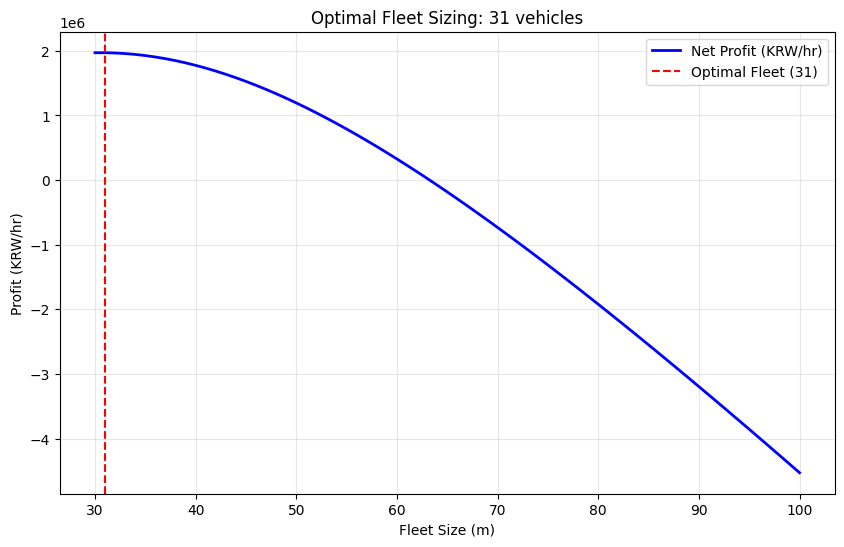

Minimum required fleet size (m_min): 30
Optimal fleet size (m*): 31
Maximum Hourly Profit: 1,970,945 KRW


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Data Loading & Preprocessing ---
# Load location data
df = pd.read_csv('data/vpt_locations.csv')
locations = df['Location'].tolist()

# Generate flight corridors (all pairs except self-loops)
flight_corridors = [(i, j) for i in locations for j in locations if i != j]

# Define all nodes in the network (Vertiports + Corridors)
nodes = locations + flight_corridors
node_idx = {node: idx for idx, node in enumerate(nodes)}
loc_index = {loc: idx for idx, loc in enumerate(locations)}

# Load System Matrices (Time, Distance, Demand, Throughput)
T = np.loadtxt('data/travel_time_matrix.csv', delimiter=',')
D = np.loadtxt('data/distance_matrix.csv', delimiter=',')
lambda_raw = np.loadtxt('data/arrival_rate_vector.csv', delimiter=',')
pi_vec = np.loadtxt('data/relative_throughput_vector.csv', delimiter=',')


# --- Input Parameters (Refined for Reality) ---
tol = 0.5             # Minimum availability requirement (Service Level Agreement)

c_fare = 3750 # KRW / km
c_usage = 7500 # 4500 KRW / ops
c_mnt = 150000 # lease cost (40,000) + battery cost (85,000) + maintenance cost (25,000) 
c_coupon = 60000 

lambda_total = 200    # Total system demand (passengers/hour)


# --- Cost & Rate Vector Calculations ---

# 1. Fare Vector (KRW per trip)
# Calculated as Distance * Fare_per_km for each corridor
c_fare_vec = np.array([
    D[loc_index[i], loc_index[j]] * c_fare for i, j in flight_corridors
])

# 2. Vertiport Usage Cost Vector (KRW per operation)
c_usage_vec = np.ones(len(locations)) * c_usage

# 3. Arrival Rate Scaling
# Normalize and scale base demand to the target total demand (lambda_total)
lambda_props = lambda_vec / np.sum(lambda_vec)
lambda_vec = lambda_props * lambda_total

# 4. Base Service Rates (mu)
# Service Rate = 1 / Service Time
n_vpt = len(locations)
n_total = len(nodes)
base_mu = np.zeros(n_total)

# For Flight Corridors (IS Nodes): Service Time = Travel Time
for f_idx, (j, k) in enumerate(flight_corridors, start=n_vpt):
    base_mu[f_idx] = 1.0 / T[loc_index[j], loc_index[k]]

# Combine Service Rates
mu_1 = np.zeros(n_total)
mu_1[:n_vpt] = lambda_vec     # Vertiports (Rate depends on arrival in single server view)
mu_1[n_vpt:] = base_mu[n_vpt:] # Corridors (Fixed travel time)

# Split Relative Throughput (pi) for easier calculation later
pi_vpt = pi_vec[:n_vpt]
pi_corridors = pi_vec[n_vpt:]


# --- ESS Algorithm (Simulation Loop) ---
# Mean Value Analysis (MVA) to find performance metrics for each fleet size (n)

obj_history = []          # Stores profit for each n
n_history = []            # Stores fleet size n
availability_history = [] # Stores availability metric

# Initialize MVA variables (Response Time W, Queue Length L)
W = [np.zeros(n_total)]
L = [np.zeros(n_total)]

m_min = -1                # Minimum fleet size to meet availability constraint
max_profit = -np.inf      # Max profit tracker
m_star = 0                # Optimal fleet size tracker

# Iterate fleet size from 1 to 100
for n in range(1, 101):
    
    # --- Step 1: Mean Value Analysis (MVA) ---
    W_vector = np.zeros(n_total)
    for node in nodes:
        idx = node_idx[node]
        if isinstance(node, tuple):  
            # Infinite Server (Flight Corridor): No queuing, W = Service Time
            W_vector[idx] = 1.0 / mu_1[idx]
        else: 
            # Single Server (Vertiport): W includes queuing time
            # W = (1 + L_prev) / ServiceRate
            if lambda_vec[loc_index[node]] > 0:
                W_vector[idx] = (1.0 + L[n - 1][idx]) / lambda_vec[loc_index[node]]
            else:
                W_vector[idx] = 0

    # Calculate System Throughput X(n) using Little's Law
    denom = np.dot(pi_vec, W_vector)
    Xn = n / denom if denom > 0 else 0

    # Update Node Queue Lengths L(n) = Throughput * VisitRatio * ResponseTime
    L_vector = Xn * pi_vec * W_vector
    
    W.append(W_vector)
    L.append(L_vector)

    # --- Step 2: Check Service Availability ---
    # Availability = Throughput / Arrival Rate (saturated if < 1.0)
    availability = []
    for loc in locations:
        lam = lambda_vec[loc_index[loc]]
        if lam > 0:
            a = (Xn * pi_vec[node_idx[loc]]) / lam
            availability.append(a)
        else:
            availability.append(1.0)
            
    availability_history.append(availability)

    # Find minimum fleet size that satisfies tolerance (e.g., > 0.5)
    if m_min == -1 and all(a >= tol for a in availability):
        m_min = n  

    # --- Step 3: Objective Function (Profit) Evaluation ---
    if m_min != -1 and n >= m_min:
        
        # [CRITICAL CORRECTION] Revenue Calculation Logic
        # We must use Flow Rate (Lambda), NOT Queue Length (Stock/L).
        # Revenue comes from passengers arriving/departing, not staying in the air.
        
        # Throughput for corridors (Flights per Hour)
        Lambda_corridors = Xn * pi_corridors
        
        # Throughput for vertiports (Operations per Hour)
        Lambda_vertiports = Xn * pi_vpt

        # Calculate Profit Terms (All units in KRW/Hour)
        # 1. Revenue = (KRW/Flight) * (Flights/Hour)
        revenue = np.dot(c_fare_vec, Lambda_corridors)
        
        # 2. Vertiport Usage = (KRW/Op) * (Ops/Hour)
        cost_vpt = np.dot(c_usage_vec, Lambda_vertiports)
        
        # 3. Maintenance = (KRW/Hour/Vehicle) * (Number of Vehicles)
        # c_mnt is already 150,000 KRW/hr (Capital + Maintenance)
        cost_mnt = c_mnt * n

        # Net Profit
        obj_n = revenue - cost_vpt - cost_mnt

        obj_history.append(obj_n)
        n_history.append(n)

        # Track Optimal Point (Maximize Profit)
        if obj_n > max_profit:
            max_profit = obj_n
            m_star = n
            
# --- Step 4: Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(n_history, obj_history, 'b-', linewidth=2, label='Net Profit (KRW/hr)')
plt.axvline(m_star, color='r', linestyle='--', label=f'Optimal Fleet ({m_star})')
plt.xlabel('Fleet Size (m)')
plt.ylabel('Profit (KRW/hr)')
plt.title(f'Optimal Fleet Sizing: {m_star} vehicles')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('result/final_optimization_result.png')
plt.show()

# Print Final Results
print(f"Minimum required fleet size (m_min): {m_min}")
print(f"Optimal fleet size (m*): {m_star}")
print(f"Maximum Hourly Profit: {max_profit:,.0f} KRW")

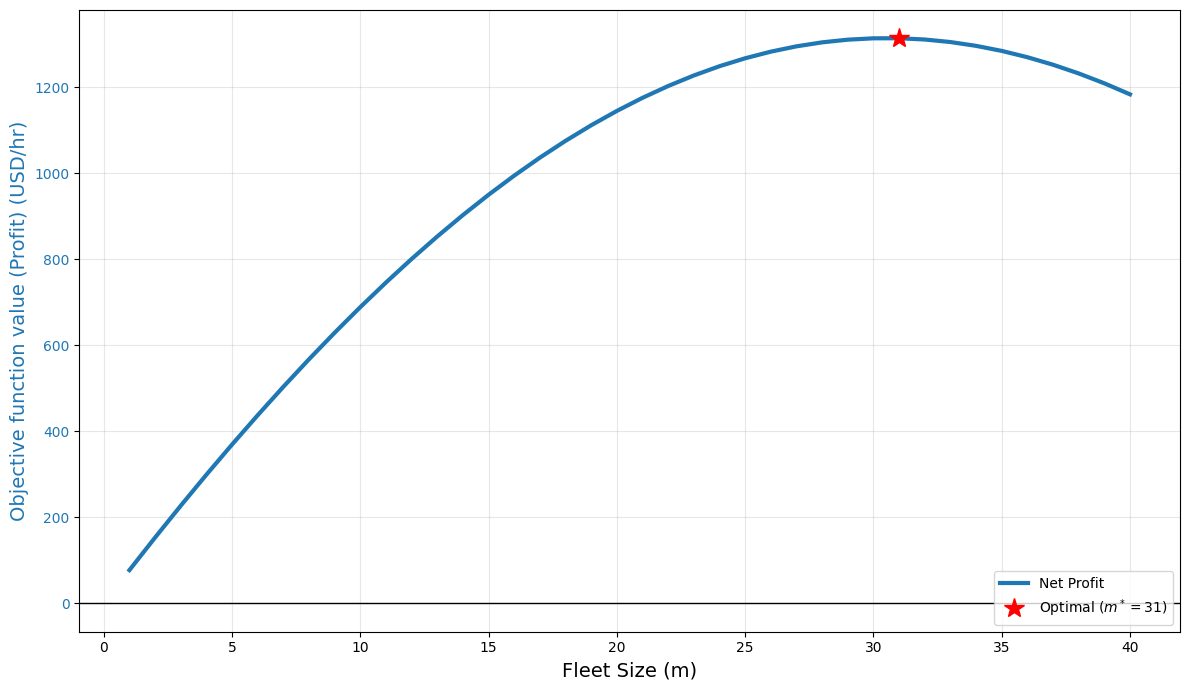

=== Simulation Results (Coupon Prob: 0) ===
Optimal Fleet Size: 31
Max Hourly Profit: 1,314 KRW
Availability at Optimal: 0.5509


In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. Data Loading ---
try:
    df = pd.read_csv('data/vpt_locations.csv')
    locations = df['Location'].tolist()
    
    flight_corridors = [(i, j) for i in locations for j in locations if i != j]
    nodes = locations + flight_corridors
    node_idx = {node: idx for idx, node in enumerate(nodes)}
    loc_index = {loc: idx for idx, loc in enumerate(locations)}

    # Load Matrices
    T = np.loadtxt('data/travel_time_matrix.csv', delimiter=',')
    D = np.loadtxt('data/distance_matrix.csv', delimiter=',')
    lambda_raw = np.loadtxt('data/arrival_rate_vector.csv', delimiter=',')
    pi_vec = np.loadtxt('data/relative_throughput_vector.csv', delimiter=',')

    # --- 2. Input Parameters (Finalized) ---
    tol = 0.5             # Target Availability
    lambda_total = 200
    
    salary = 30000 # KRW / hr (Korean Technician)
    r_overhead = 1.5 # 150% of salary
    t_tat = 10 # min / ops
    
    # [Cost]
    c_fare = 3750 # KRW / km
    c_usage = 7500 # 7500 KRW / ops
    c_mnt = 150000 # lease cost (40,000) + battery cost (85,000) + maintenance cost (25,000) 
    c_coupon = 60000  # $40
    prob_coupon = 0
    KRW_TO_USD = 1 / 1500

    # --- 3. Vector Calculations ---
    c_fare_vec = np.array([
        D[loc_index[i], loc_index[j]] * c_fare for i, j in flight_corridors
    ])
    c_usage_vec = np.ones(len(locations)) * c_usage

    lambda_props = lambda_vec / np.sum(lambda_vec)
    lambda_vec = lambda_props * lambda_total

    n_vpt = len(locations)
    n_total = len(nodes)
    base_mu = np.zeros(n_total)

    for f_idx, (j, k) in enumerate(flight_corridors, start=n_vpt):
        base_mu[f_idx] = 1.0 / T[loc_index[j], loc_index[k]]

    mu_1 = np.zeros(n_total)
    mu_1[:n_vpt] = lambda_vec
    mu_1[n_vpt:] = base_mu[n_vpt:]

    pi_vpt = pi_vec[:n_vpt]
    pi_corridors = pi_vec[n_vpt:]


    # --- 4. Simulation Loop ---
    obj_history = []
    n_history = []
    availability_history = []
    
    W = [np.zeros(n_total)]
    L = [np.zeros(n_total)]

    m_min = -1
    max_profit = -np.inf
    m_star = 0

    # Changed range to 41 to include 40
    for n in range(1, 41):
        # MVA Step
        W_vector = np.zeros(n_total)
        for node in nodes:
            idx = node_idx[node]
            if isinstance(node, tuple):
                W_vector[idx] = 1.0 / mu_1[idx]
            else:
                if lambda_vec[loc_index[node]] > 0:
                    W_vector[idx] = (1.0 + L[n - 1][idx]) / lambda_vec[loc_index[node]]
                else:
                    W_vector[idx] = 0

        denom = np.dot(pi_vec, W_vector)
        Xn = n / denom if denom > 0 else 0

        L_vector = Xn * pi_vec * W_vector
        W.append(W_vector)
        L.append(L_vector)

        # Availability Check
        avail = []
        for loc in locations:
            lam = lambda_vec[loc_index[loc]]
            if lam > 0:
                a = (Xn * pi_vec[node_idx[loc]]) / lam
                avail.append(a)
            else:
                avail.append(1.0)
        
        avg_avail = np.mean(avail)
        availability_history.append(avg_avail)

        if m_min == -1 and all(a >= tol for a in avail):
            m_min = n

        # Profit Calculation
            
        Lambda_corridors = Xn * pi_corridors
        Lambda_vertiports = Xn * pi_vpt
        
        revenue = np.dot(c_fare_vec, Lambda_corridors)
        cost_vpt = np.dot(c_usage_vec, Lambda_vertiports)
        cost_mnt = c_mnt * n
        
        # [수정된 쿠폰 로직]
        # 전체 이탈 승객 수 계산
        lost_demand_vec = np.maximum(lambda_vec - Lambda_vertiports, 0)
        total_lost = np.sum(lost_demand_vec)
        
        # 확률적 지급 (Expected Cost)
        # 비용 = (이탈 승객) * (지급 확률) * (쿠폰 가격)
        cost_coupon = total_lost * prob_coupon * c_coupon

        obj_n = revenue - cost_vpt - cost_mnt - cost_coupon

        obj_n_used = obj_n * KRW_TO_USD

        obj_history.append(obj_n_used)
        n_history.append(n)

        if obj_n_used > max_profit:
            max_profit = obj_n_used
            m_star = n

    # --- 5. Visualization ---
    fig, ax1 = plt.figure(figsize=(12, 7)), plt.gca()

    # Profit
    color = 'tab:blue'
    ax1.set_xlabel('Fleet Size (m)', fontsize=14)
    ax1.set_ylabel('Objective function value (Profit) (USD/hr)', color=color, fontsize=14)
    ax1.plot(n_history, obj_history, color=color, linewidth=3, label='Net Profit')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', linewidth=1, linestyle='-')

    # Availability
    # ax2 = ax1.twinx()
    # color = 'tab:green'
    # ax2.set_ylabel('Avg. Availability', color=color, fontsize=14)
    # # Adjust x-axis for availability history to match fleet size range (1 to 40)
    # ax2.plot(range(1, 41), availability_history, color=color, linestyle='--', label='Availability')
    # ax2.tick_params(axis='y', labelcolor=color)
    # ax2.set_ylim(0, 1.1)

    # Optimal Point
    if m_star > 0:
        ax1.plot(m_star, max_profit, 'r*', markersize=15, label=f'Optimal ($m^*={m_star}$)')
    
    # Legend setup
    lines1, labels1 = ax1.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1, labels1, loc='lower right')
    plt.tight_layout()
    plt.savefig('result/fleet_size_obj_val.png') # Updated filename
    plt.show()

    print(f"=== Simulation Results (Coupon Prob: {prob_coupon}) ===")
    print(f"Optimal Fleet Size: {m_star}")
    print(f"Max Hourly Profit: {max_profit:,.0f} KRW")
    
    if m_star > 0:
        print(f"Availability at Optimal: {availability_history[m_star-1]:.4f}")
    else:
        print("No optimal fleet size found in range.")

except Exception as e:
    print(f"Error: {e}")

Running Sensitivity Analysis on Coupon Probability...
Prob       | m*    | Net Profit      | Compensation Cost
-------------------------------------------------------
  0%      | 31    | 1,314 USD    | 0 USD
 20%      | 36    | 651 USD    | 619 USD
 40%      | 41    | 72 USD    | 1,084 USD
 60%      | 44    | -448 USD    | 1,504 USD
 80%      | 48    | -925 USD    | 1,816 USD
100%      | 50    | -1,369 USD    | 2,165 USD


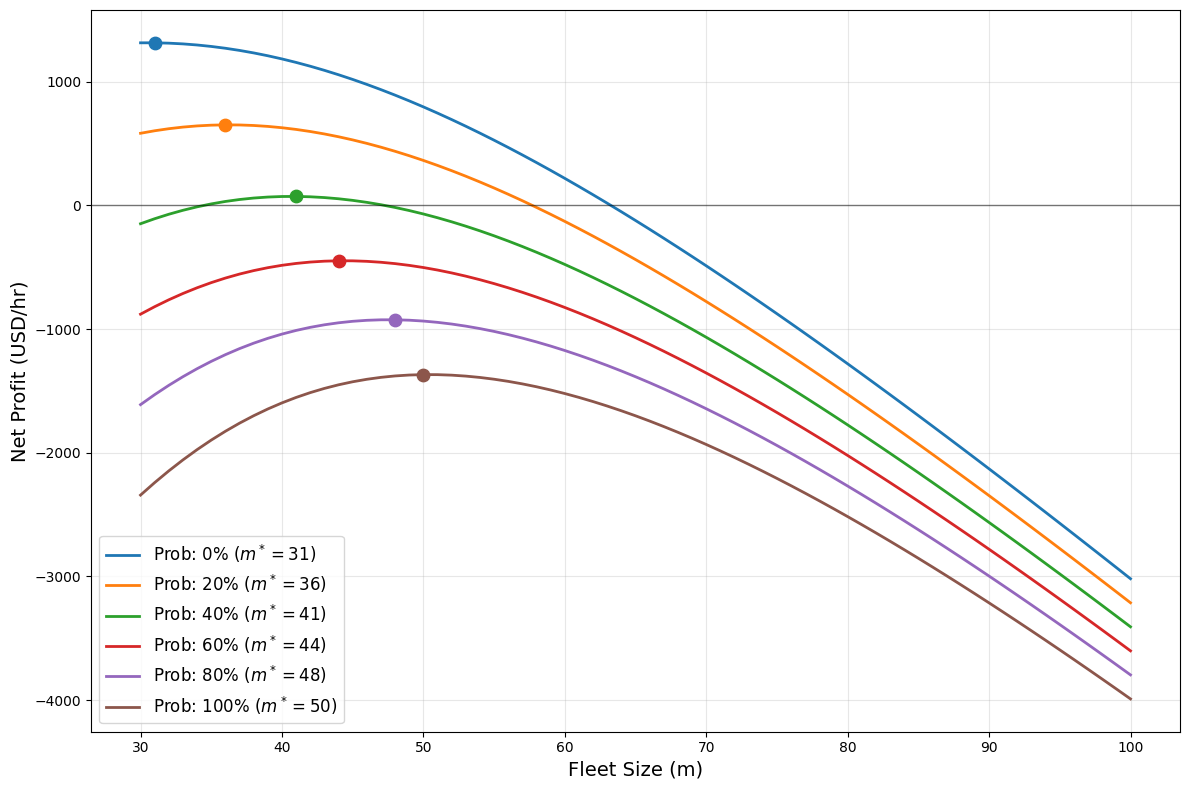

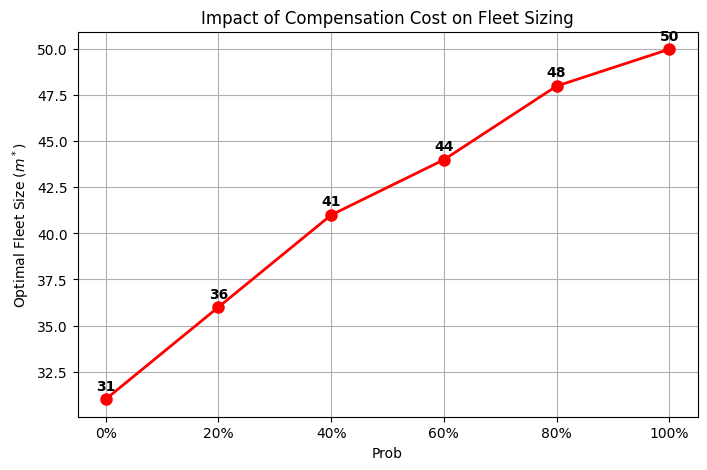

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. Data Loading & Setup ---
try:
    # Assuming data files are present in the current directory or 'data/' subdirectory
    # Adjust paths as necessary for your environment
    df = pd.read_csv('data/vpt_locations.csv')
    locations = df['Location'].tolist()
    flight_corridors = [(i, j) for i in locations for j in locations if i != j]
    nodes = locations + flight_corridors
    node_idx = {node: idx for idx, node in enumerate(nodes)}
    loc_index = {loc: idx for idx, loc in enumerate(locations)}

    # Load Matrices
    T = np.loadtxt('data/travel_time_matrix.csv', delimiter=',')
    D = np.loadtxt('data/distance_matrix.csv', delimiter=',')
    lambda_raw = np.loadtxt('data/arrival_rate_vector.csv', delimiter=',')
    pi_vec = np.loadtxt('data/relative_throughput_vector.csv', delimiter=',')

    # --- 2. Fixed Parameters ---
    tol = 0.5
    lambda_total = 200
    
    c_fare = 3750 # KRW / km
    c_usage = 7500 # 4500 KRW / ops
    c_mnt = 150000 # lease cost (40,000) + battery cost (85,000) + maintenance cost (25,000) 
    c_coupon = 60000 
    KRW_TO_USD = 1 / 1500

    # --- 3. Pre-calculation ---
    c_fare_vec = np.array([D[loc_index[i], loc_index[j]] * c_fare for i, j in flight_corridors])
    c_usage_vec = np.ones(len(locations)) * c_usage
    
    # Normalize arrival rate vector
    lambda_vec = (lambda_raw / np.sum(lambda_raw)) * lambda_total
    
    n_vpt = len(locations)
    n_total = len(nodes)
    base_mu = np.zeros(n_total)
    for f_idx, (j, k) in enumerate(flight_corridors, start=n_vpt):
        base_mu[f_idx] = 1.0 / T[loc_index[j], loc_index[k]]
        
    mu_1 = np.zeros(n_total)
    mu_1[:n_vpt] = lambda_vec
    mu_1[n_vpt:] = base_mu[n_vpt:]
    
    pi_vpt = pi_vec[:n_vpt]
    pi_corridors = pi_vec[n_vpt:]

    # --- 4. Sensitivity Analysis Loop ---
    # Probabilities to analyze: 0%, 20%, 40%, 60%, 80%, 100%
    probs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    sensitivity_results = {}  # Dictionary to store results

    print(f"Running Sensitivity Analysis on Coupon Probability...")
    print(f"{'Prob':<10} | {'m*':<5} | {'Net Profit':<15} | {'Compensation Cost':<15}")
    print("-" * 55)

    plt.figure(figsize=(12, 8))

    for p in probs:
        prob_coupon = p
        
        # Initialize simulation variables
        W = [np.zeros(n_total)]
        L = [np.zeros(n_total)]
        m_min = -1
        max_profit = -np.inf
        m_star = 0
        final_coupon_cost = 0 # Initialize to avoid UnboundLocalError if loop doesn't find feasible m
        
        obj_curve = []
        fleet_curve = []

        # Fleet Size Loop (1~100)
        for n in range(1, 101):
            # MVA
            W_vector = np.zeros(n_total)
            for node in nodes:
                idx = node_idx[node]
                if isinstance(node, tuple):
                    W_vector[idx] = 1.0 / mu_1[idx]
                else:
                    if lambda_vec[loc_index[node]] > 0:
                        # Handling L[n-1] which corresponds to previous fleet size
                        # L list is 0-indexed, so L[n-1] is correct for previous state
                        W_vector[idx] = (1.0 + L[n - 1][idx]) / lambda_vec[loc_index[node]]
                    else:
                        W_vector[idx] = 0

            denom = np.dot(pi_vec, W_vector)
            Xn = n / denom if denom > 0 else 0
            L_vector = Xn * pi_vec * W_vector
            W.append(W_vector)
            L.append(L_vector)

            # Availability Check
            avail = []
            for loc in locations:
                lam = lambda_vec[loc_index[loc]]
                if lam > 0:
                    avail.append((Xn * pi_vec[node_idx[loc]]) / lam)
                else:
                    avail.append(1.0)

            # Check if minimum availability constraint is met
            if m_min == -1 and all(a >= tol for a in avail):
                m_min = n

            # Profit Calculation (only if availability constraint is met)
            if m_min != -1 and n >= m_min:
                Lambda_corridors = Xn * pi_corridors
                Lambda_vertiports = Xn * pi_vpt
                
                revenue = np.dot(c_fare_vec, Lambda_corridors)
                cost_vpt = np.dot(c_usage_vec, Lambda_vertiports)
                cost_mnt = c_mnt * n
                
                # [Coupon Cost] = Lost Passengers * Probability * Coupon Value
                lost_demand = np.maximum(lambda_vec - Lambda_vertiports, 0).sum()
                cost_coupon_val = lost_demand * prob_coupon * c_coupon 
                
                # Profit in KRW
                obj_n = revenue - cost_vpt - cost_mnt - cost_coupon_val
                
                # Convert Profit to USD
                obj_n_usd = obj_n * KRW_TO_USD

                obj_curve.append(obj_n_usd)
                fleet_curve.append(n)
                
                if obj_n_usd > max_profit:
                    max_profit = obj_n_usd
                    m_star = n
                    final_coupon_cost = cost_coupon_val * KRW_TO_USD

        # Store results
        sensitivity_results[p] = {
            'm_star': m_star,
            'max_profit': max_profit,
            'n_values': fleet_curve,
            'obj_values': obj_curve
        }
        print(f"{p*100:>3.0f}%      | {m_star:<5} | {max_profit:,.0f} USD    | {final_coupon_cost:,.0f} USD")

        # Plot Curve
        plt.plot(fleet_curve, obj_curve, linewidth=2, label=f'Prob: {p*100:.0f}% ($m^*={m_star}$)')
        # Mark Optimal Point
        plt.scatter(m_star, max_profit, s=80, zorder=5)

    # --- 5. Visualization Setup (Profit Curve) ---
    plt.xlabel('Fleet Size (m)', fontsize=14)
    plt.ylabel('Net Profit (USD/hr)', fontsize=14)
    # plt.title(f'Sensitivity Analysis for Compensation Probability)', fontsize=16)
    plt.axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    # Create directory if not exists
    os.makedirs('result', exist_ok=True)
    plt.savefig('result/sensitivity_analysis_coupon.png')
    plt.show()

    # --- 6. Additional Analysis: Optimal Fleet Size vs Probability ---
    plt.figure(figsize=(8, 5))
    x_val = [k for k in sensitivity_results.keys()]
    y_val = [v['m_star'] for v in sensitivity_results.values()]
    
    plt.plot(x_val, y_val, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Prob')
    plt.ylabel('Optimal Fleet Size ($m^*$)')
    plt.title('Impact of Compensation Cost on Fleet Sizing')
    plt.grid(True)
    plt.xticks(x_val, [f"{x*100:.0f}%" for x in x_val])
    
    for x, y in zip(x_val, y_val):
        plt.text(x, y + 0.5, str(y), ha='center', fontweight='bold')

    plt.savefig('result/sensitivity_m_star.png')
    plt.show()

except Exception as e:
    print(f"Error: {e}")

Running Sensitivity Analysis on Coupon Probability...
Prob       | m*    | Net Profit      | Compensation Cost
-------------------------------------------------------
  0%       | 31    | 1,314 USD    | 0 USD
 20%       | 36    | 651 USD    | 619 USD
 40%       | 41    | 72 USD    | 1,084 USD
 60%       | 44    | -448 USD    | 1,504 USD
 80%       | 48    | -925 USD    | 1,816 USD
100%       | 50    | -1,369 USD    | 2,165 USD


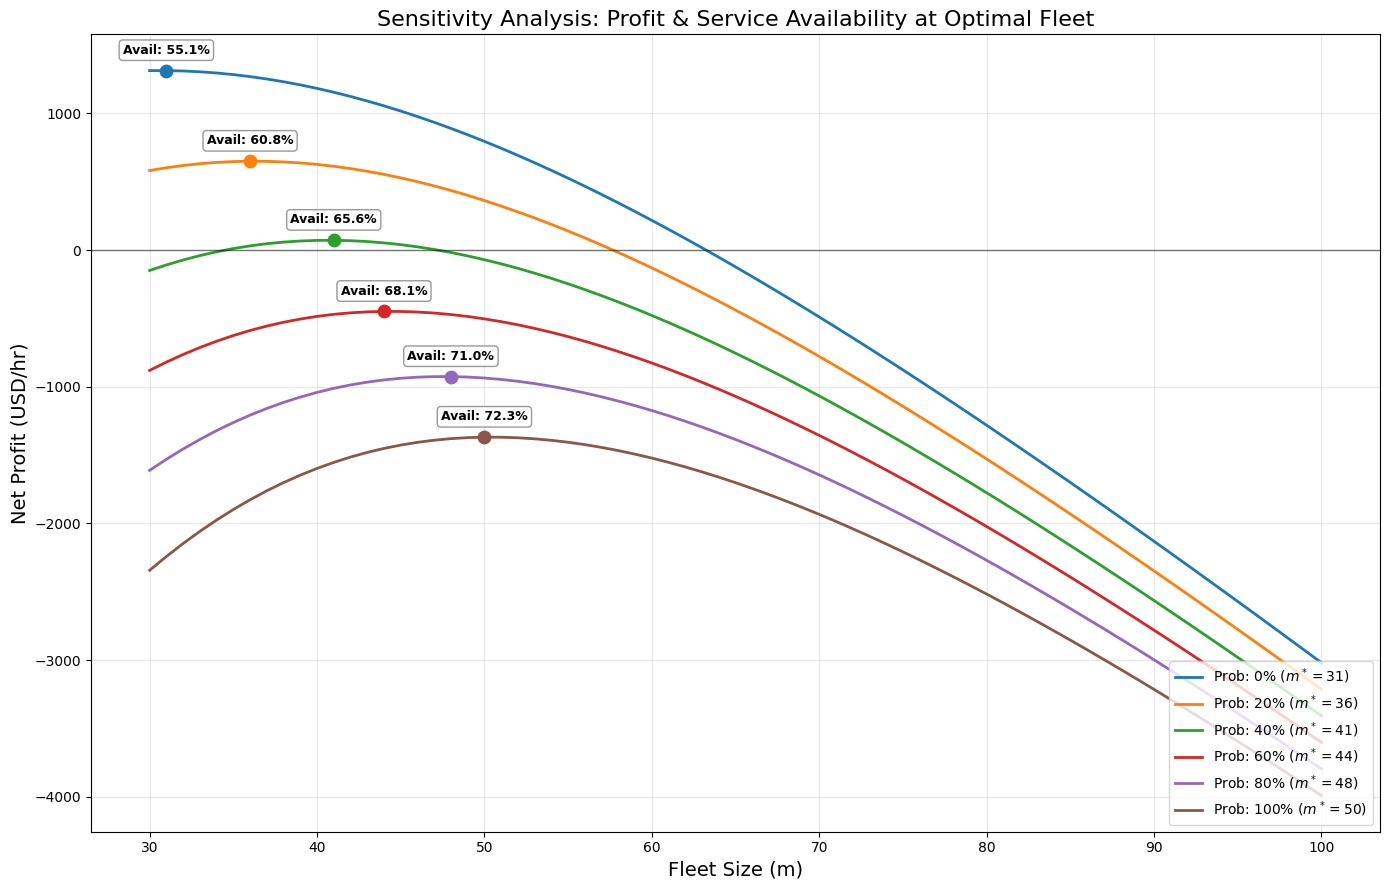

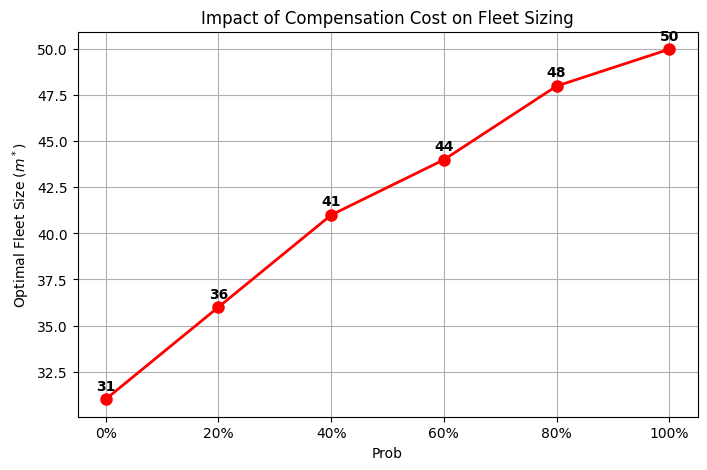

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. Data Loading & Setup ---
try:
    # Assuming data files are present in the current directory or 'data/' subdirectory
    # Adjust paths as necessary for your environment
    df = pd.read_csv('data/vpt_locations.csv')
    locations = df['Location'].tolist()
    flight_corridors = [(i, j) for i in locations for j in locations if i != j]
    nodes = locations + flight_corridors
    node_idx = {node: idx for idx, node in enumerate(nodes)}
    loc_index = {loc: idx for idx, loc in enumerate(locations)}

    # Load Matrices
    T = np.loadtxt('data/travel_time_matrix.csv', delimiter=',')
    D = np.loadtxt('data/distance_matrix.csv', delimiter=',')
    lambda_raw = np.loadtxt('data/arrival_rate_vector.csv', delimiter=',')
    pi_vec = np.loadtxt('data/relative_throughput_vector.csv', delimiter=',')

    # --- 2. Fixed Parameters ---
    tol = 0.5
    lambda_total = 200
    
    c_fare = 3750 # KRW / km
    c_usage = 7500 # 4500 KRW / ops
    c_mnt = 150000 # lease cost (40,000) + battery cost (85,000) + maintenance cost (25,000) 
    c_coupon = 60000 
    KRW_TO_USD = 1 / 1500

    # --- 3. Pre-calculation ---
    c_fare_vec = np.array([D[loc_index[i], loc_index[j]] * c_fare for i, j in flight_corridors])
    c_usage_vec = np.ones(len(locations)) * c_usage
    
    # Normalize arrival rate vector
    lambda_vec = (lambda_raw / np.sum(lambda_raw)) * lambda_total
    
    n_vpt = len(locations)
    n_total = len(nodes)
    base_mu = np.zeros(n_total)
    for f_idx, (j, k) in enumerate(flight_corridors, start=n_vpt):
        base_mu[f_idx] = 1.0 / T[loc_index[j], loc_index[k]]
        
    mu_1 = np.zeros(n_total)
    mu_1[:n_vpt] = lambda_vec
    mu_1[n_vpt:] = base_mu[n_vpt:]
    
    pi_vpt = pi_vec[:n_vpt]
    pi_corridors = pi_vec[n_vpt:]

    # --- 4. Sensitivity Analysis Loop ---
    # Probabilities to analyze: 0%, 20%, 40%, 60%, 80%, 100%
    probs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    sensitivity_results = {}  # Dictionary to store results

    print(f"Running Sensitivity Analysis on Coupon Probability...")
    print(f"{'Prob':<10} | {'m*':<5} | {'Net Profit':<15} | {'Compensation Cost':<15}")
    print("-" * 55)

    plt.figure(figsize=(14, 9)) # 그래프 크기를 조금 키웠습니다

    for p in probs:
        prob_coupon = p
        
        # Initialize simulation variables
        W = [np.zeros(n_total)]
        L = [np.zeros(n_total)]
        m_min = -1
        max_profit = -np.inf
        m_star = 0
        final_coupon_cost = 0 
        
        # --- [수정됨] 최적점에서의 가용성을 저장할 변수 초기화 ---
        m_star_avail_avg = 0 
        
        obj_curve = []
        fleet_curve = []

        # Fleet Size Loop (1~100)
        for n in range(1, 101):
            # MVA
            W_vector = np.zeros(n_total)
            for node in nodes:
                idx = node_idx[node]
                if isinstance(node, tuple):
                    W_vector[idx] = 1.0 / mu_1[idx]
                else:
                    if lambda_vec[loc_index[node]] > 0:
                        W_vector[idx] = (1.0 + L[n - 1][idx]) / lambda_vec[loc_index[node]]
                    else:
                        W_vector[idx] = 0

            denom = np.dot(pi_vec, W_vector)
            Xn = n / denom if denom > 0 else 0
            L_vector = Xn * pi_vec * W_vector
            W.append(W_vector)
            L.append(L_vector)

            # Availability Check
            avail = []
            for loc in locations:
                lam = lambda_vec[loc_index[loc]]
                if lam > 0:
                    avail.append((Xn * pi_vec[node_idx[loc]]) / lam)
                else:
                    avail.append(1.0)

            # Check if minimum availability constraint is met
            if m_min == -1 and all(a >= tol for a in avail):
                m_min = n

            # Profit Calculation (only if availability constraint is met)
            if m_min != -1 and n >= m_min:
                Lambda_corridors = Xn * pi_corridors
                Lambda_vertiports = Xn * pi_vpt
                
                revenue = np.dot(c_fare_vec, Lambda_corridors)
                cost_vpt = np.dot(c_usage_vec, Lambda_vertiports)
                cost_mnt = c_mnt * n
                
                # [Coupon Cost]
                lost_demand = np.maximum(lambda_vec - Lambda_vertiports, 0).sum()
                cost_coupon_val = lost_demand * prob_coupon * c_coupon 
                
                # Profit in KRW
                obj_n = revenue - cost_vpt - cost_mnt - cost_coupon_val
                
                # Convert Profit to USD
                obj_n_usd = obj_n * KRW_TO_USD

                obj_curve.append(obj_n_usd)
                fleet_curve.append(n)
                
                if obj_n_usd > max_profit:
                    max_profit = obj_n_usd
                    m_star = n
                    final_coupon_cost = cost_coupon_val * KRW_TO_USD
                    
                    # --- [수정됨] 최적 Fleet일 때의 평균 가용성(Service Availability) 저장 ---
                    m_star_avail_avg = np.mean(avail)

        # Store results
        sensitivity_results[p] = {
            'm_star': m_star,
            'max_profit': max_profit,
            'n_values': fleet_curve,
            'obj_values': obj_curve
        }
        print(f"{p*100:>3.0f}%       | {m_star:<5} | {max_profit:,.0f} USD    | {final_coupon_cost:,.0f} USD")

        # Plot Curve
        line_label = f'Prob: {p*100:.0f}% ($m^*={m_star}$)'
        plt.plot(fleet_curve, obj_curve, linewidth=2, label=line_label)
        
        # Mark Optimal Point
        plt.scatter(m_star, max_profit, s=80, zorder=5)
        
        # --- [수정됨] 그래프 상에 Availability 정보 텍스트 추가 ---
        # 최적점 바로 위에 텍스트 표시 (m* 값과 Avg Avail 표시)
        if m_star > 0:
            annotation_text = f"Avail: {m_star_avail_avg:.1%}"
            plt.annotate(annotation_text, 
                         xy=(m_star, max_profit), 
                         xytext=(0, 10), # 점보다 10포인트 위쪽
                         textcoords='offset points',
                         ha='center', va='bottom',
                         fontsize=9,
                         fontweight='bold',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    # --- 5. Visualization Setup (Profit Curve) ---
    plt.xlabel('Fleet Size (m)', fontsize=14)
    plt.ylabel('Net Profit (USD/hr)', fontsize=14)
    plt.title('Sensitivity Analysis: Profit & Service Availability at Optimal Fleet', fontsize=16) # 제목 변경
    plt.axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10, loc='lower right') # 범례 위치 조정
    
    plt.tight_layout()
    # Create directory if not exists
    os.makedirs('result', exist_ok=True)
    plt.savefig('result/sensitivity_analysis_avail.png')
    plt.show()

    # --- 6. Additional Analysis: Optimal Fleet Size vs Probability ---
    plt.figure(figsize=(8, 5))
    x_val = [k for k in sensitivity_results.keys()]
    y_val = [v['m_star'] for v in sensitivity_results.values()]
    
    plt.plot(x_val, y_val, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Prob')
    plt.ylabel('Optimal Fleet Size ($m^*$)')
    plt.title('Impact of Compensation Cost on Fleet Sizing')
    plt.grid(True)
    plt.xticks(x_val, [f"{x*100:.0f}%" for x in x_val])
    
    for x, y in zip(x_val, y_val):
        plt.text(x, y + 0.5, str(y), ha='center', fontweight='bold')

    plt.savefig('result/sensitivity_m_star.png')
    plt.show()

except Exception as e:
    print(f"Error: {e}")

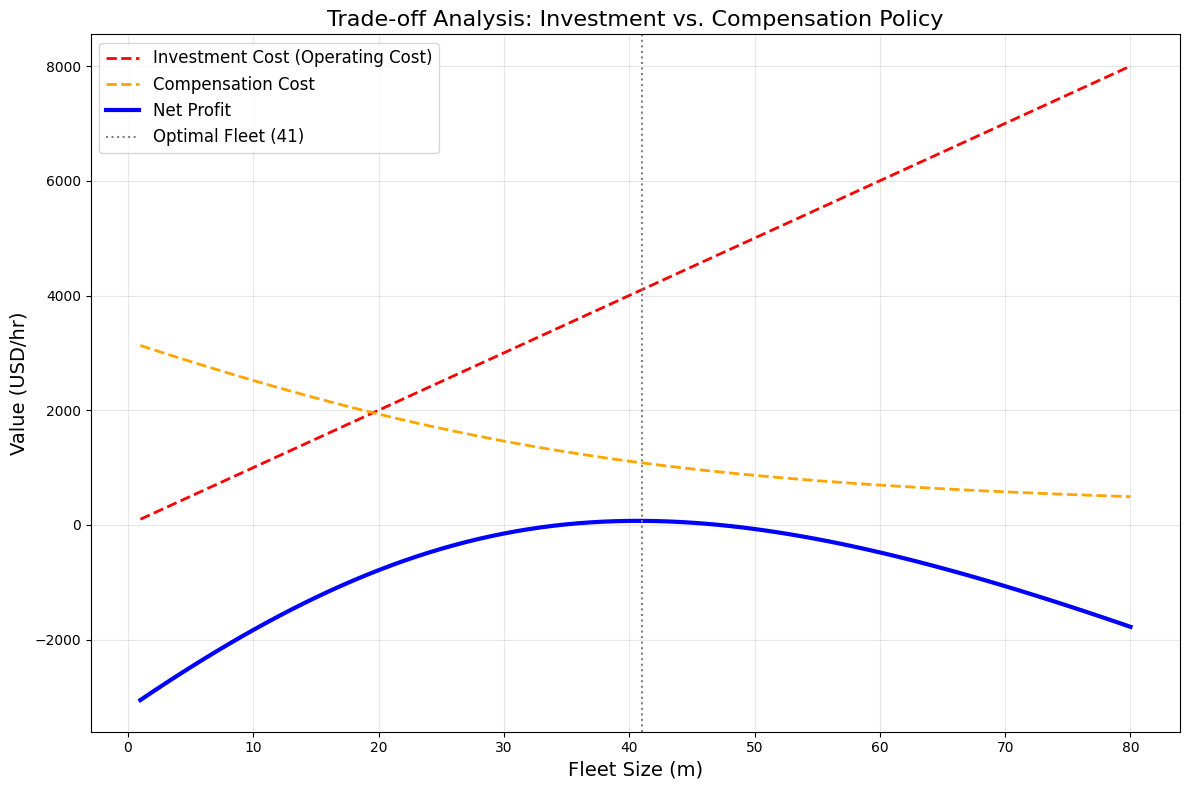

Optimal Fleet Size: 41


In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. Data Loading ---
try:
    df = pd.read_csv('data/vpt_locations.csv')
    locations = df['Location'].tolist()
    flight_corridors = [(i, j) for i in locations for j in locations if i != j]
    nodes = locations + flight_corridors
    node_idx = {node: idx for idx, node in enumerate(nodes)}
    loc_index = {loc: idx for idx, loc in enumerate(locations)}

    T = np.loadtxt('data/travel_time_matrix.csv', delimiter=',')
    D = np.loadtxt('data/distance_matrix.csv', delimiter=',')
    lambda_raw = np.loadtxt('data/arrival_rate_vector.csv', delimiter=',')
    pi_vec = np.loadtxt('data/relative_throughput_vector.csv', delimiter=',')

    # --- 2. Parameters (Final Optimized) ---
    tol = 0.5
    lambda_total = 200
    
    # Exchange rate for plot labels
    KRW_TO_USD = 1 / 1500

    c_fare = 3750 # KRW / km
    c_usage = 7500 # KRW / ops
    c_mnt = 150000 # lease cost (40,000) + battery cost (85,000) + maintenance cost (25,000) 
    c_coupon = 60000 
    
    prob_coupon = 0.4

    # --- 3. Prep ---
    c_fare_vec = np.array([D[loc_index[i], loc_index[j]] * c_fare for i, j in flight_corridors])
    c_usage_vec = np.ones(len(locations)) * c_usage
    lambda_vec = (lambda_raw / np.sum(lambda_raw)) * lambda_total
    
    n_total = len(nodes)
    n_vpt = len(locations)
    base_mu = np.zeros(n_total)
    for f_idx, (j, k) in enumerate(flight_corridors, start=n_vpt):
        base_mu[f_idx] = 1.0 / T[loc_index[j], loc_index[k]]
    mu_1 = np.zeros(n_total)
    mu_1[:n_vpt] = lambda_vec
    mu_1[n_vpt:] = base_mu[n_vpt:]
    pi_vpt = pi_vec[:n_vpt]
    pi_corridors = pi_vec[n_vpt:]

    # --- 4. Simulation for Cost Components ---
    n_values = range(1, 81)
    
    # Store component values
    costs_mnt = []    # Investment Cost (Rising)
    costs_pen = []    # Penalty Cost (Falling)
    costs_ops = []    # Operation Cost (Rising with throughput)
    revenues = []     # Revenue (Rising with throughput)
    profits = []      # Total Profit
    
    W = [np.zeros(n_total)]
    L = [np.zeros(n_total)]
    
    m_star = 0
    max_profit = -np.inf

    for n in n_values:
        # MVA
        W_vector = np.zeros(n_total)
        for node in nodes:
            idx = node_idx[node]
            if isinstance(node, tuple):
                W_vector[idx] = 1.0 / mu_1[idx]
            else:
                if lambda_vec[loc_index[node]] > 0:
                    W_vector[idx] = (1.0 + L[n - 1][idx]) / lambda_vec[loc_index[node]]
                else:
                    W_vector[idx] = 0
        
        denom = np.dot(pi_vec, W_vector)
        Xn = n / denom if denom > 0 else 0
        L_vector = Xn * pi_vec * W_vector
        W.append(W_vector)
        L.append(L_vector)

        # Calculate Components
        Lambda_corridors = Xn * pi_corridors
        Lambda_vertiports = Xn * pi_vpt
        
        # 1. Investment Cost (Maintenance + Lease) -> Linear Increase
        val_mnt = c_mnt * n
        
        # 2. Penalty Cost (Coupon) -> Exponential Decay
        lost_demand = np.maximum(lambda_vec - Lambda_vertiports, 0).sum()
        val_pen = lost_demand * prob_coupon * c_coupon
        
        # 3. Revenue & Ops Cost
        val_rev = np.dot(c_fare_vec, Lambda_corridors)
        val_ops = np.dot(c_usage_vec, Lambda_vertiports)
        
        # Total Profit
        val_profit = val_rev - val_ops - val_mnt - val_pen
        
        # Convert all values to USD for plotting
        costs_mnt.append(val_mnt * KRW_TO_USD)
        costs_pen.append(val_pen * KRW_TO_USD)
        costs_ops.append(val_ops * KRW_TO_USD)
        revenues.append(val_rev * KRW_TO_USD)
        profits.append(val_profit * KRW_TO_USD)
        
        if val_profit > max_profit:
            max_profit = val_profit
            m_star = n
            
    # Convert max_profit to USD for annotation or printing if needed locally
    # The loop stores USD values in the lists, but max_profit variable still holds the last KRW value check
    # Let's find the max profit in USD directly from the list
    max_profit_usd = max(profits)


    # --- 5. Visualization: The Trade-off Plot ---
    plt.figure(figsize=(12, 8))
    
    # A. Investment Cost (Fleet)
    plt.plot(n_values, costs_mnt, color='red', linestyle='--', linewidth=2, label='Investment Cost (Operating Cost)')
    
    # B. Penalty Cost (Lost Demand)
    plt.plot(n_values, costs_pen, color='orange', linestyle='--', linewidth=2, label='Compensation Cost')
    
    # C. Total Profit (Result)
    plt.plot(n_values, profits, color='blue', linewidth=3, label='Net Profit')
    
    # Optimal Line
    plt.axvline(m_star, color='grey', linestyle=':', label=f'Optimal Fleet ({m_star})')
    
    plt.xlabel('Fleet Size (m)', fontsize=14)
    plt.ylabel('Value (USD/hr)', fontsize=14)
    plt.title('Trade-off Analysis: Investment vs. Compensation Policy', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    
    # Add annotations (adjusting y-position based on USD scale)
    # Using approximate index for placement
    idx_anno = 10 
    idx_anno2 = 20
    # plt.text(n_values[idx_anno], costs_mnt[idx_anno], 'Operating Cost Increases', color='red', rotation=25)
    # plt.text(n_values[idx_anno2], costs_pen[idx_anno2], 'Compensation Cost Decreases', color='orange')

    plt.tight_layout()
    plt.savefig('result/fig_tradeoff_analysis.png')
    plt.show()
    
    print(f"Optimal Fleet Size: {m_star}")

except Exception as e:
    print(f"Error: {e}")